In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules
REPO_DIR = '..' if IN_COLAB  else '..'

# Imports

In [2]:
import IPython.display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pickle

In [3]:
sns.set_style('ticks')
sns.set_context('talk', font_scale=1.5)
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['savefig.dpi'] = 72
matplotlib.rcParams['savefig.pad_inches'] = 0.0
matplotlib.rcParams['savefig.transparent'] = True
matplotlib.rcParams['axes.linewidth'] = 2.5
matplotlib.rcParams['legend.markerscale'] = 2.0
matplotlib.rcParams['legend.fontsize'] = 'small'
# Make colab/jupyter plots HD.
IPython.display.set_matplotlib_formats('retina')

/opt/conda/envs/graph_attribution/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  del sys.path[0]


In [4]:
task_names = ['benzene', 'logic7', 'logic8', 'logic10', 'crippen']
model_names = ['gcn', 'gat', 'mpnn', 'graphnet']
att_model_names = ['GradInput', 'SmoothGrad(GradInput)', 'GradCAM-last', 'GradCAM-all', 'IG', 'CAM', 'EGSAR']

In [5]:
task_to_att_key = {
    'crippen': ('tau', 'ATT tau'),
    'benzene': ('AUROC', 'ATT AUROC'),
    'logic7': ('AUROC', 'ATT AUROC'),
    'logic8': ('AUROC', 'ATT AUROC'),
    'logic10': ('AUROC', 'ATT AUROC')
}

In [6]:
nicenames = {
    'ACC': 'Accuracy',
    'ATT AUROC': 'Attribution auROC',
    'ATT tau': 'Attribution Kendall $\\tau$',
    'ATT r': 'Attribution Pearson $r$',
    'AttWeights': 'Attention Weights',
#     'graphnet': 'GraphNets',
    'graphnet': 'GNs',
    'gcn': 'GCN',
    'mpnn': 'MPNN',
    'gat': 'GAT',
    'block_type': '',
    'Technique': '',
    'SmoothGrad(GradInput)': 'SmoothGrad(GI)',
    'l2_reg': 'L2 Reg. Coeff.',
    '(amine & ether2 & benzene)': 'Amine AND Ether AND Benzene',
    '(flouride & carbonyl)': 'Fluoride AND Carbonyl',
    '(unbranched alkane & carbonyl)': 'Unbranched Alkane AND Carbonyl',
    'Random': 'Random Baseline',
    'benzene': 'Benzene',
    'logic7': 'Fluoride AND Carbonyl',
    'logic8': 'Unbranched Alkane AND Carbonyl',
    'logic10': 'Amine AND Ether AND Benzene',
    'crippen': 'CrippenLogP'
}

def get_nicename(x):
    if x in nicenames.keys():
        return nicenames[x]
    else:
        return x


def plot_nice_legend(ax=None):
    if ax is None:
        legend = plt.legend(bbox_to_anchor=(1, 1), frameon=False)
    else:
        legend = ax.legend(bbox_to_anchor=(1, 1), frameon=False)
    for t in legend.get_texts():
        t.set_text(get_nicename(t.get_text()))


def label_nicenames(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set_xlabel(get_nicename(ax.get_xlabel()))
    ax.set_ylabel(get_nicename(ax.get_ylabel()))
    ax.set_xticklabels(
        [get_nicename(x.get_text()) for x in ax.get_xticklabels()])

# Attribution method accuracy across tasks and model architecture

In [7]:
with open('../data/egsar_results_gcn&gan&mpnn&graphnet(5_trials).pickle', 'rb') as f:
    results = pickle.load(f)

In [8]:
len(results)

100

In [9]:
to_cat = []
for key, res in results.items():
    r = res.copy()
    r['block_type'] = key[0]
    r['task_type'] = key[1]
    r['Trial'] = key[2]
    to_cat.append(r)

In [10]:
df_exp_result = pd.concat(to_cat)

In [11]:
tabledf = []
for task in task_names:
    attr_metric = task_to_att_key[task][-1]
    for model in model_names:
        for att_model in att_model_names + ['Random']:
            idx = (df_exp_result.block_type == model) & \
                (df_exp_result.task_type == task) & \
                (df_exp_result.Technique == att_model)
            mean = df_exp_result[attr_metric][idx].mean()

            res = {
              'Model': get_nicename(model),
              'Attribution Model': get_nicename(att_model),
              'Task': get_nicename(task),
              'Attribution Performance': np.round(mean, 2)
            }
            tabledf.append(res)
tabledf = pd.DataFrame(tabledf)

In [12]:
tabledf.tail()

,Model,Attribution Model,Task,Attribution Performance
155,GNs,GradCAM-all,CrippenLogP,0.22
156,GNs,IG,CrippenLogP,0.14
157,GNs,CAM,CrippenLogP,0.10
158,GNs,EGSAR,CrippenLogP,0.09
159,GNs,Random Baseline,CrippenLogP,0.13


In [13]:
dispdf = tabledf.pivot_table(
    index='Attribution Model',
    columns=('Task', 'Model'),
    values='Attribution Performance',
    aggfunc=lambda x: x)

dispdf = dispdf.reindex(columns=[get_nicename(n) for n in task_names], level='Task')\
               .reindex(columns=[get_nicename(m) for m in model_names], level='Model')\
               .reindex(index=[get_nicename(m) for m in ['Random'] + att_model_names])\
               .rename_axis(None)
dispdf

Task            Benzene                   Fluoride AND Carbonyl              \
Model               GCN   GAT  MPNN   GNs                   GCN   GAT  MPNN   
Random Baseline    0.61  0.61  0.61  0.61                  0.41  0.42  0.42   
GradInput          0.65  0.57  0.57  0.51                  0.58  0.49  0.59   
SmoothGrad(GI)     0.65  0.56  0.59  0.51                  0.63  0.49  0.60   
GradCAM-last       0.66  0.66  0.66  0.53                  0.59  0.59  0.70   
GradCAM-all        0.67  0.64  0.60  0.55                  0.56  0.54  0.59   
IG                 0.86  0.85  0.97  0.98                  0.65  0.61  0.70   
CAM                0.99  0.97  0.98  0.73                  0.71  0.66  0.78   
EGSAR              0.97  0.94  0.99  0.86                  0.76  0.68  0.81   

Task                  Unbranched Alkane AND Carbonyl                    \
Model             GNs                            GCN   GAT  MPNN   GNs   
Random Baseline  0.42                           0.50  0.50  0.49  0.50   
GradInput        0.54                           0.55  0.52  0.58  0.59   
SmoothGrad(GI)   0.54                           0.52  0.41  0.62  0.64   
GradCAM-last     0.33                           0.59  0.58  0.85  0.53   
GradCAM-all      0.62                           0.56  0.56  0.62  0.62   
IG               0.67                           0.64  0.64  0.70  0.72   
CAM              0.35                           0.91  0.87  0.94  0.69   
EGSAR            0.65                           0.87  0.85  0.88  0.55   

Task            Amine AND Ether AND Benzene                   CrippenLogP  \
Model                                   GCN   GAT  MPNN   GNs         GCN   
Random Baseline                        0.51  0.50  0.50  0.50        0.13   
GradInput                              0.48  0.38  0.52  0.51        0.25   
SmoothGrad(GI)                         0.48  0.37  0.58  0.55        0.23   
GradCAM-last                           0.48  0.48  0.66  0.43       -0.05   
GradCAM-all                            0.49  0.43  0.54  0.73       -0.00   
IG                                     0.61  0.54  0.62  0.74        0.31   
CAM                                    0.63  0.68  0.73  0.50        0.07   
EGSAR                                  0.73  0.72  0.74  0.47        0.18   

Task                               
Model             GAT  MPNN   GNs  
Random Baseline  0.13  0.13  0.13  
GradInput        0.14  0.06  0.16  
SmoothGrad(GI)   0.13  0.09  0.18  
GradCAM-last     0.04  0.28  0.08  
GradCAM-all      0.02  0.23  0.22  
IG               0.23  0.06  0.14  
CAM              0.11  0.38  0.10  
EGSAR            0.02  0.40  0.09

In [14]:
dispdf.rank(ascending=False)

Task            Benzene                Fluoride AND Carbonyl                 \
Model               GCN  GAT MPNN  GNs                   GCN  GAT MPNN  GNs   
Random Baseline     8.0  6.0  5.0  4.0                   8.0  8.0  8.0  6.0   
GradInput           6.5  7.0  8.0  7.5                   6.0  6.5  6.5  4.5   
SmoothGrad(GI)      6.5  8.0  7.0  7.5                   4.0  6.5  5.0  4.5   
GradCAM-last        5.0  4.0  4.0  6.0                   5.0  4.0  3.5  8.0   
GradCAM-all         4.0  5.0  6.0  5.0                   7.0  5.0  6.5  3.0   
IG                  3.0  3.0  3.0  1.0                   3.0  3.0  3.5  1.0   
CAM                 1.0  1.0  2.0  3.0                   2.0  2.0  2.0  7.0   
EGSAR               2.0  2.0  1.0  2.0                   1.0  1.0  1.0  2.0   

Task            Unbranched Alkane AND Carbonyl                 \
Model                                      GCN  GAT MPNN  GNs   
Random Baseline                            8.0  7.0  8.0  8.0   
GradInput                                  6.0  6.0  7.0  5.0   
SmoothGrad(GI)                             7.0  8.0  5.5  3.0   
GradCAM-last                               4.0  4.0  3.0  7.0   
GradCAM-all                                5.0  5.0  5.5  4.0   
IG                                         3.0  3.0  4.0  1.0   
CAM                                        1.0  1.0  1.0  2.0   
EGSAR                                      2.0  2.0  2.0  6.0   

Task            Amine AND Ether AND Benzene                CrippenLogP       \
Model                                   GCN  GAT MPNN  GNs         GCN  GAT   
Random Baseline                         4.0  4.0  8.0  5.5         5.0  3.5   
GradInput                               7.0  7.0  7.0  4.0         2.0  2.0   
SmoothGrad(GI)                          7.0  8.0  5.0  3.0         3.0  3.5   
GradCAM-last                            7.0  5.0  3.0  8.0         8.0  6.0   
GradCAM-all                             5.0  6.0  6.0  2.0         7.0  7.5   
IG                                      3.0  3.0  4.0  1.0         1.0  1.0   
CAM                                     2.0  2.0  2.0  5.5         6.0  5.0   
EGSAR                                   1.0  1.0  1.0  7.0         4.0  7.5   

Task                       
Model           MPNN  GNs  
Random Baseline  5.0  5.0  
GradInput        7.5  3.0  
SmoothGrad(GI)   6.0  2.0  
GradCAM-last     3.0  8.0  
GradCAM-all      4.0  1.0  
IG               7.5  4.0  
CAM              2.0  6.0  
EGSAR            1.0  7.0

In [15]:
print(sum(dispdf.rank(ascending=False).loc["EGSAR",:]==1))
print(sum(dispdf.rank(ascending=False).loc["EGSAR",:]==2))
print(sum(dispdf.rank(ascending=False).loc["IG",:]==1))
print(sum(dispdf.rank(ascending=False).loc["IG",:]==2))
print(sum(dispdf.rank(ascending=False).loc["CAM",:]==1))
print(sum(dispdf.rank(ascending=False).loc["CAM",:]==2))

8
7
6
0
5
9


In [16]:
# Average rank 
np.round(np.mean(dispdf.rank(ascending=False), axis=1),2)

Random Baseline    6.20
GradInput          5.80
SmoothGrad(GI)     5.50
GradCAM-last       5.28
GradCAM-all        4.97
IG                 2.80
CAM                2.78
EGSAR              2.68
dtype: float64

In [17]:
# Average rank for best combination for each task
dispdf_best = pd.DataFrame({})
for tn in [get_nicename(n) for n in task_names]:
    dispdf_best[tn] = dispdf.loc[:,tn].max(axis=1)
print(dispdf_best.rank(ascending=False))

                 Benzene  Fluoride AND Carbonyl  \
Random Baseline      8.0                    8.0   
GradInput            6.5                    7.0   
SmoothGrad(GI)       6.5                    5.0   
GradCAM-last         5.0                    3.5   
GradCAM-all          4.0                    6.0   
IG                   3.0                    3.5   
CAM                  1.5                    2.0   
EGSAR                1.5                    1.0   

                 Unbranched Alkane AND Carbonyl  Amine AND Ether AND Benzene  \
Random Baseline                             8.0                          8.0   
GradInput                                   7.0                          7.0   
SmoothGrad(GI)                              5.0                          6.0   
GradCAM-last                                3.0                          5.0   
GradCAM-all                                 6.0                          3.5   
IG                                          4.0             

In [18]:
print(np.round(np.mean(dispdf_best.rank(ascending=False),axis=1),2))

Random Baseline    8.0
GradInput          6.5
SmoothGrad(GI)     5.8
GradCAM-last       4.1
GradCAM-all        5.2
IG                 3.0
CAM                2.0
EGSAR              1.4
dtype: float64


In [19]:
table1_df = tabledf[tabledf['Task'].isin(['Benzene', 'Amine AND Ether AND Benzene', 'Fluoride AND Carbonyl', 'Unbranched Alkane AND Carbonyl', 'CrippenLogP'])]

In [20]:
top = cm.get_cmap('Oranges', 128)
middle = [[1, 1, 1, 1]]
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, int(np.round(0.34 * 256)))),
                       np.repeat(middle, int(np.round(0.16 * 256)), axis=0),
                       bottom(np.linspace(0, 1, int(np.round(0.5 * 256))))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [21]:
dispdf = table1_df.pivot_table(
    index='Attribution Model',
    columns=('Task', 'Model'),
    values='Attribution Performance',
    aggfunc=lambda x: x)

dispdf = dispdf.reindex(columns=[get_nicename(n) for n in task_names], level='Task')\
               .reindex(columns=[get_nicename(m) for m in model_names], level='Model')\
               .reindex(index=[get_nicename(m) for m in ['Random'] + att_model_names])\
               .rename_axis(None)

In [22]:
dispdf

Task            Benzene                   Fluoride AND Carbonyl              \
Model               GCN   GAT  MPNN   GNs                   GCN   GAT  MPNN   
Random Baseline    0.61  0.61  0.61  0.61                  0.41  0.42  0.42   
GradInput          0.65  0.57  0.57  0.51                  0.58  0.49  0.59   
SmoothGrad(GI)     0.65  0.56  0.59  0.51                  0.63  0.49  0.60   
GradCAM-last       0.66  0.66  0.66  0.53                  0.59  0.59  0.70   
GradCAM-all        0.67  0.64  0.60  0.55                  0.56  0.54  0.59   
IG                 0.86  0.85  0.97  0.98                  0.65  0.61  0.70   
CAM                0.99  0.97  0.98  0.73                  0.71  0.66  0.78   
EGSAR              0.97  0.94  0.99  0.86                  0.76  0.68  0.81   

Task                  Unbranched Alkane AND Carbonyl                    \
Model             GNs                            GCN   GAT  MPNN   GNs   
Random Baseline  0.42                           0.50  0.50  0.49  0.50   
GradInput        0.54                           0.55  0.52  0.58  0.59   
SmoothGrad(GI)   0.54                           0.52  0.41  0.62  0.64   
GradCAM-last     0.33                           0.59  0.58  0.85  0.53   
GradCAM-all      0.62                           0.56  0.56  0.62  0.62   
IG               0.67                           0.64  0.64  0.70  0.72   
CAM              0.35                           0.91  0.87  0.94  0.69   
EGSAR            0.65                           0.87  0.85  0.88  0.55   

Task            Amine AND Ether AND Benzene                   CrippenLogP  \
Model                                   GCN   GAT  MPNN   GNs         GCN   
Random Baseline                        0.51  0.50  0.50  0.50        0.13   
GradInput                              0.48  0.38  0.52  0.51        0.25   
SmoothGrad(GI)                         0.48  0.37  0.58  0.55        0.23   
GradCAM-last                           0.48  0.48  0.66  0.43       -0.05   
GradCAM-all                            0.49  0.43  0.54  0.73       -0.00   
IG                                     0.61  0.54  0.62  0.74        0.31   
CAM                                    0.63  0.68  0.73  0.50        0.07   
EGSAR                                  0.73  0.72  0.74  0.47        0.18   

Task                               
Model             GAT  MPNN   GNs  
Random Baseline  0.13  0.13  0.13  
GradInput        0.14  0.06  0.16  
SmoothGrad(GI)   0.13  0.09  0.18  
GradCAM-last     0.04  0.28  0.08  
GradCAM-all      0.02  0.23  0.22  
IG               0.23  0.06  0.14  
CAM              0.11  0.38  0.10  
EGSAR            0.02  0.40  0.09

In [23]:
top = cm.get_cmap('Oranges', 128)
middle = [[1, 1, 1, 1]]
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 0, int(np.round(0 * 256)))),
                       np.repeat(middle, int(np.round(0.16 * 256)), axis=0),
                       bottom(np.linspace(0, 1, int(np.round(0.5 * 256))))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

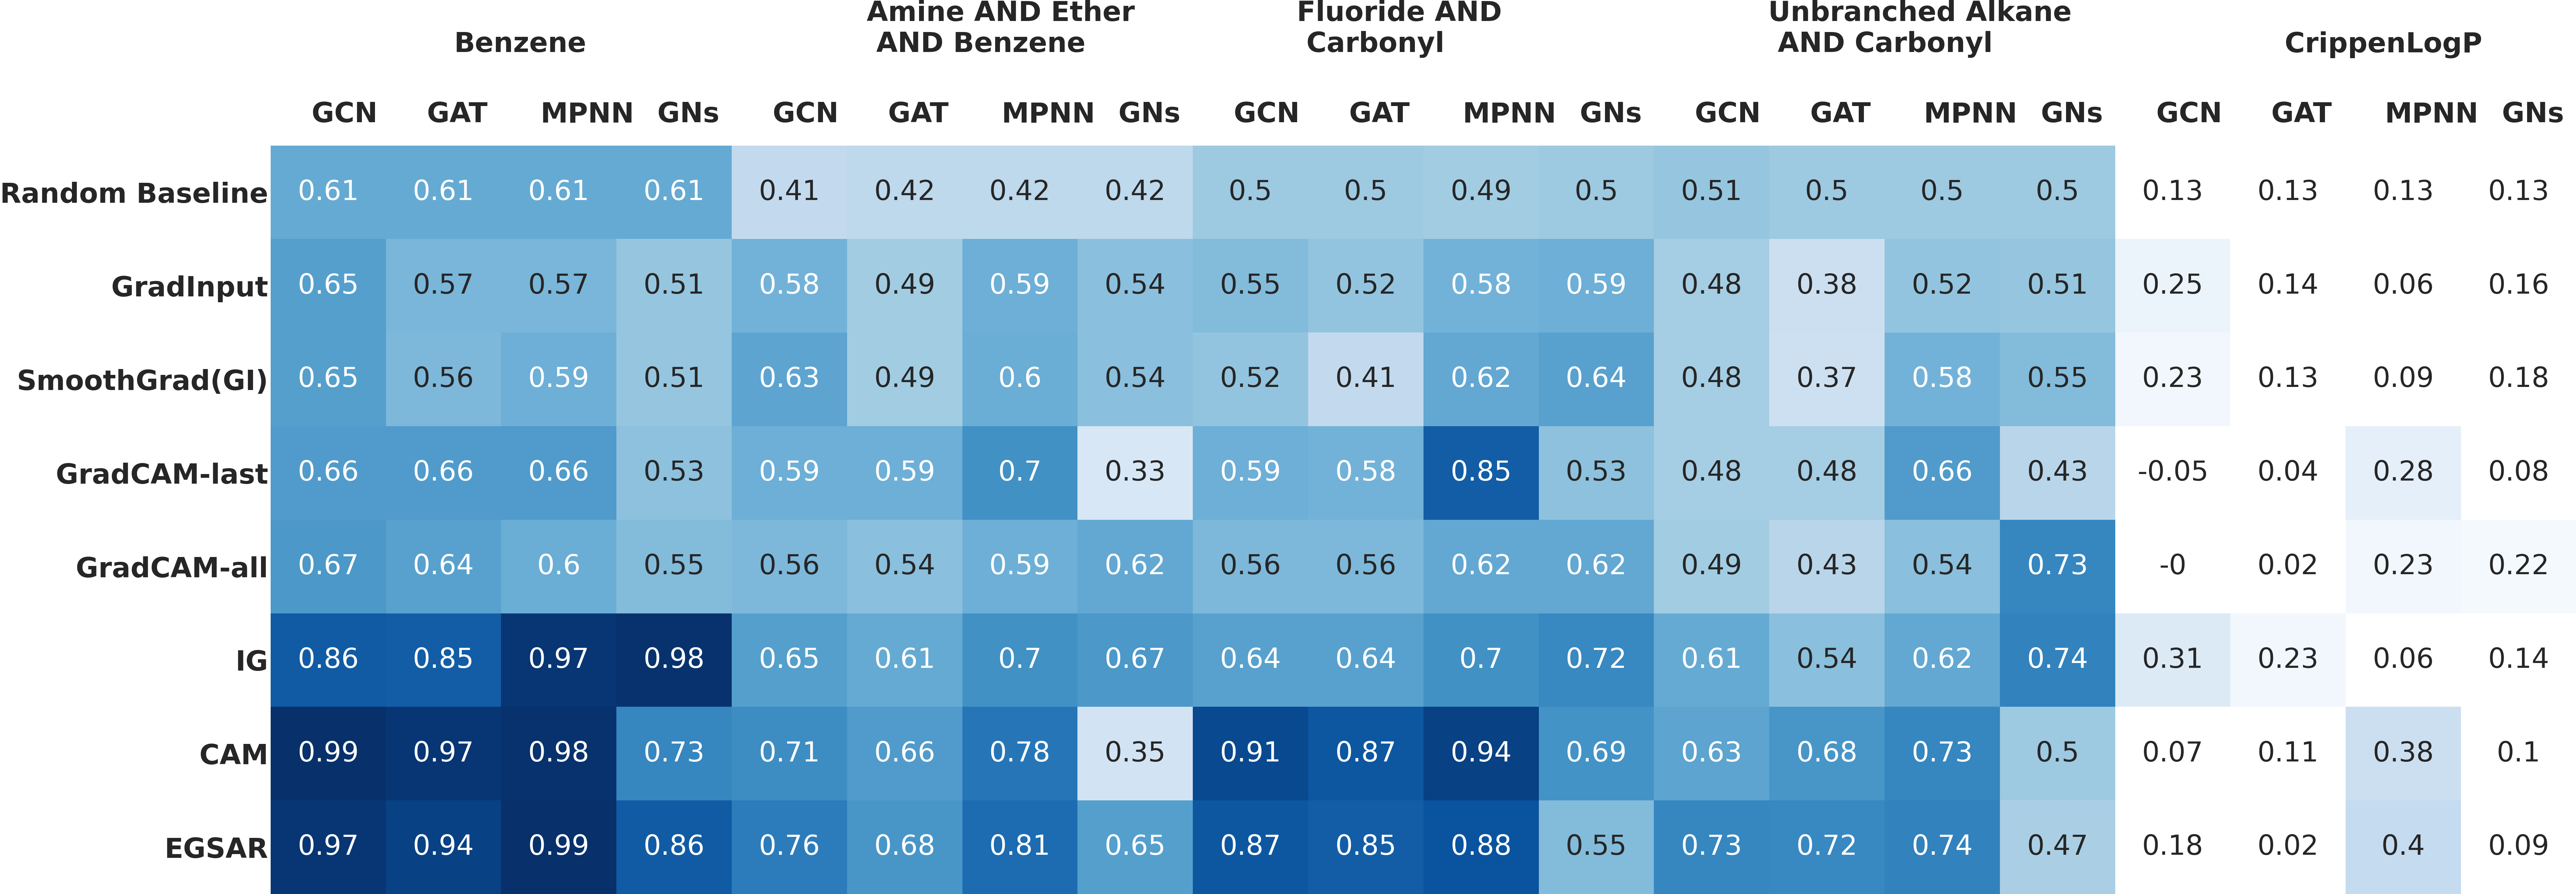

In [56]:
fig = plt.figure(figsize=(60, 20))
ax = sns.heatmap(dispdf, cmap=newcmp, annot=True, ax=plt.gca(), cbar=False)
ax.xaxis.tick_top()
ax.tick_params(length=0)
fsize = 40
fweight = 'semibold'
matplotlib.rcParams['font.size'] = fsize
matplotlib.rcParams['savefig.pad_inches'] = 0.0
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fsize, fontweight = fweight)
check = 0
for i, t in enumerate(ax.get_xticklabels()):
    pos = t.get_position()
    text = t.get_text()
    task, model = text.split('-')
    plt.text(i + 0.4 - len(model) * .015, -.25, model, fontsize=fsize, fontweight = fweight)
    if i % 4 == 1:
        if check == 0:
            plt.text(i + 0.8 - len(task) * .03, -1, 'Benzene', fontsize=fsize, fontweight = fweight)
        if check == 1:
            plt.text(i + 0.8 - len(task) * .03, -1, 'Amine AND Ether \n AND Benzene', fontsize=fsize, fontweight = fweight)
        if check == 2:
            plt.text(i + 0.8 - len(task) * .03, -1, 'Fluoride AND \n Carbonyl', fontsize=fsize, fontweight = fweight)
        if check == 3:
            plt.text(i + 0.8 - len(task) * .03, -1, 'Unbranched Alkane \n AND Carbonyl', fontsize=fsize, fontweight = fweight)
        if check == 4:
            plt.text(i + 0.8 - len(task) * .03, -1, 'CrippenLogP', fontsize=fsize, fontweight = fweight)
        check = check+1

ax.set_xticklabels([]);
plt.xlabel('');
fig.savefig('figure2.png', format='png', bbox_inches='tight', pad_inches=0)

In [25]:
df_exp_result_fig4_cls = df_exp_result[df_exp_result['task_type']!="crippen"]
df_exp_result_fig4_cls.head()

,ATT AUROC,ATT F1,ATT ACC,AUROC,F1,ACC,Task,Technique,Model,block_type,task_type,Trial,ATT tau,ATT r,R2,RMSE,tau
0,0.614214,0.269102,0.271483,0.999862,0.9995,0.9995,benzene,Random,gcn,gcn,benzene,0,NaN,NaN,NaN,NaN,NaN
1,0.657501,0.290926,0.427524,0.999862,0.9995,0.9995,benzene,GradInput,gcn,gcn,benzene,0,NaN,NaN,NaN,NaN,NaN
2,0.659991,0.290149,0.434932,0.999862,0.9995,0.9995,benzene,SmoothGrad(GradInput),gcn,gcn,benzene,0,NaN,NaN,NaN,NaN,NaN
3,0.681524,0.306249,0.554356,0.999862,0.9995,0.9995,benzene,GradCAM-last,gcn,gcn,benzene,0,NaN,NaN,NaN,NaN,NaN
4,0.704313,0.304460,0.507810,0.999862,0.9995,0.9995,benzene,GradCAM-all,gcn,gcn,benzene,0,NaN,NaN,NaN,NaN,NaN


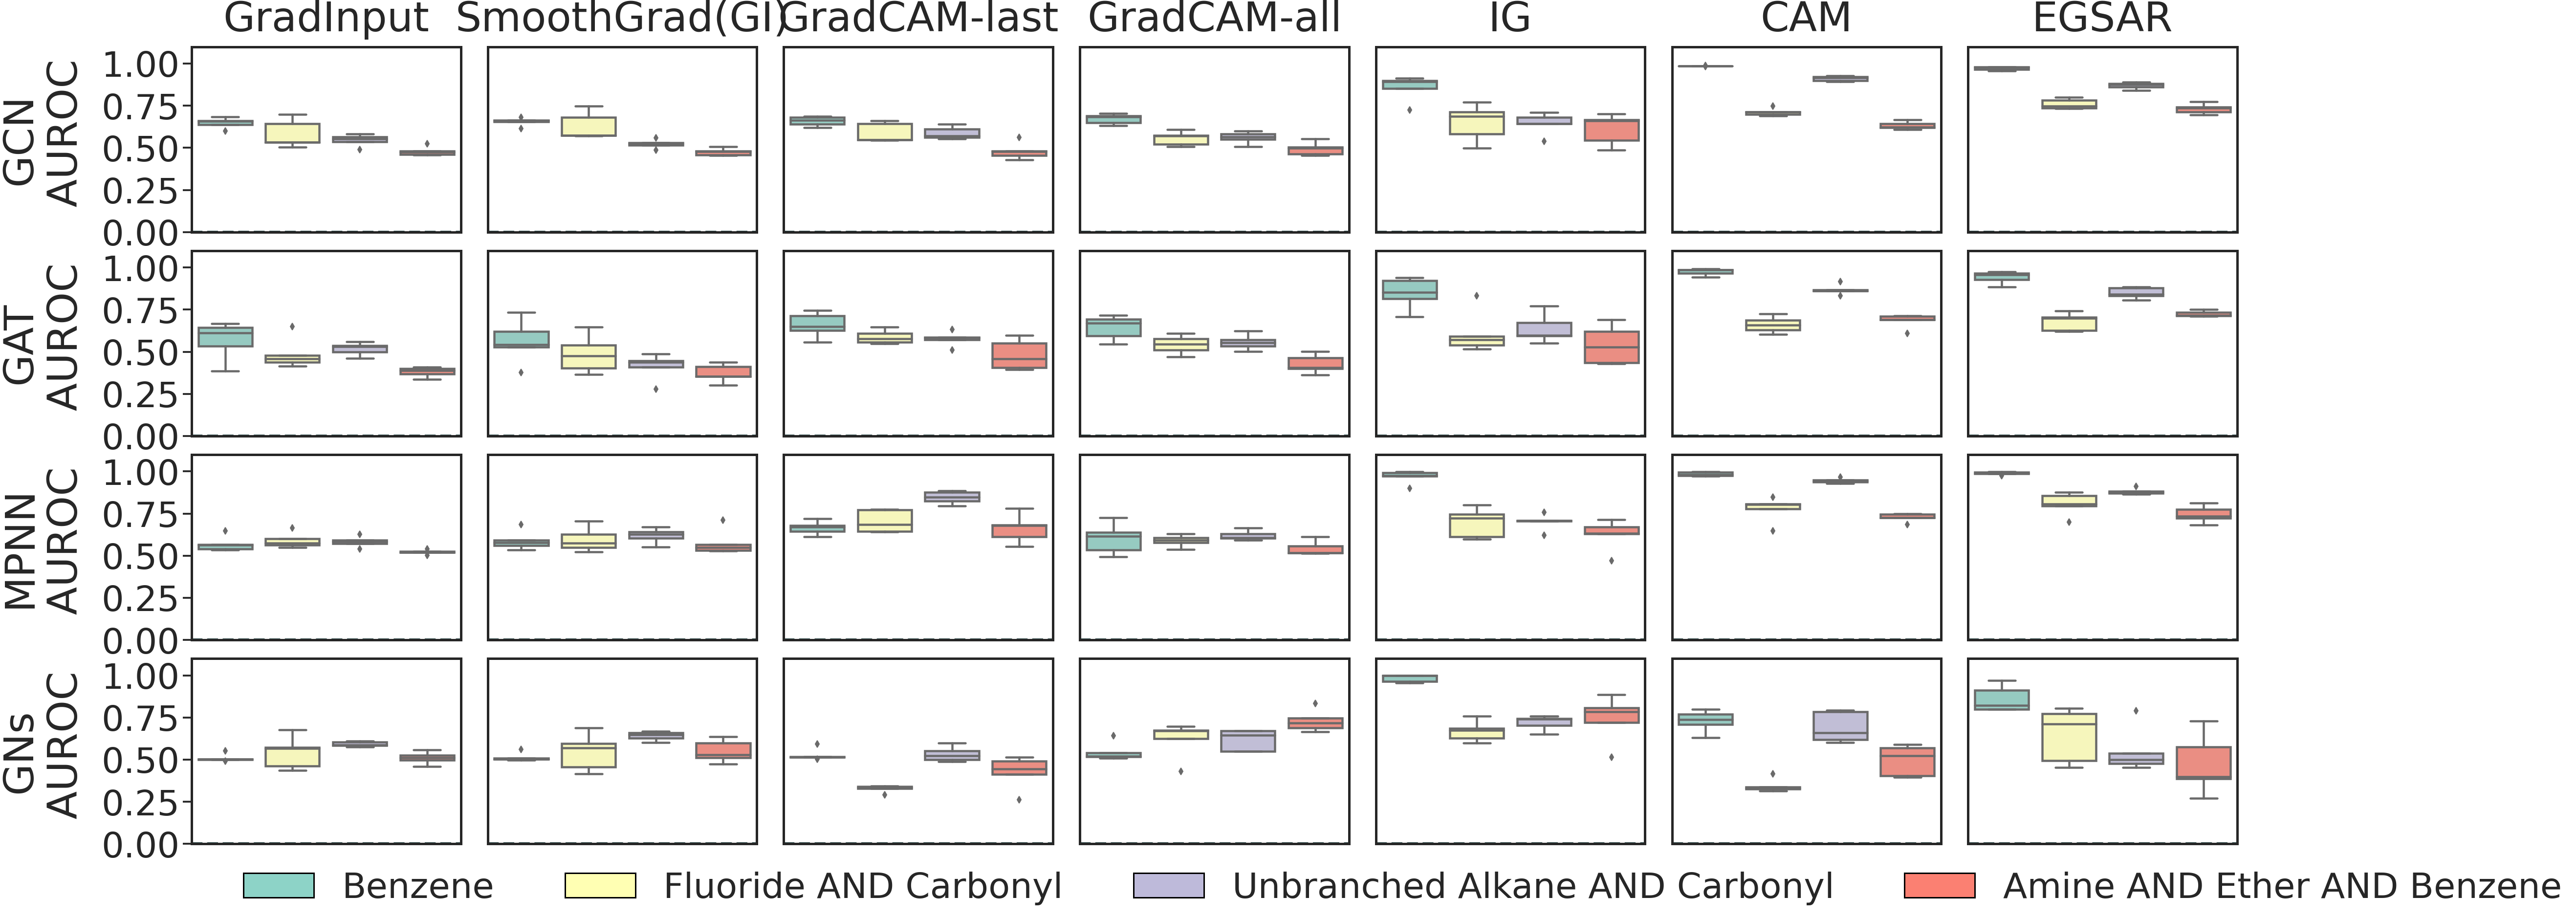

In [26]:
FIG_HEIGHT = 15
FIG_WIDTH_RATIO = 2.5
GRID_PADDING = 0.1
PALLETE = 'Set3'

fig_4_task_names = ['benzene', 'logic7', 'logic8', 'logic10']
fig_4_att_model_names = ['GradInput', 'SmoothGrad(GradInput)', 'GradCAM-last', 'GradCAM-all', 'IG', 'CAM', 'EGSAR']

fig, axes = plt.subplots(
    nrows=len(model_names),
    ncols=len(fig_4_att_model_names),
    figsize=(FIG_HEIGHT * FIG_WIDTH_RATIO, FIG_HEIGHT),
)
draw_legend_ax = None

for block_idx, block_name in enumerate(model_names):
    for tech_idx, technique_name in enumerate(fig_4_att_model_names):

        # get the dataframe
        tmp_df = df_exp_result_fig4_cls.query('Technique=="{}" and block_type=="{}"'.format(
            technique_name, block_name))

        # draw figures
        ax = plt.subplot(
            len(model_names), len(fig_4_att_model_names),
            1 + block_idx * len(fig_4_att_model_names) + tech_idx)
        sns.boxplot(
            x='task_type',
            y='ATT AUROC',
            data=tmp_df,
            palette=PALLETE,
            order=fig_4_task_names)
        plt.axhline(0, linestyle='--', color='darkslategray', linewidth=3)
        plt.ylabel('')
        plt.xlabel('')
        plt.xticks([], [])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
        plt.ylim(0, 1.1)

        # setup grid
        if block_idx == 0:
            plt.title(get_nicename(technique_name), pad=16, fontsize=42)
        if tech_idx == 0:
            ax.set_ylabel(
              '{}\n AUROC'.format(get_nicename(block_name)),
              labelpad=16,
              fontsize=42)
        if tech_idx != 0:
            plt.yticks([], [])
        else:
            ax.tick_params(axis='y', labelsize=36)
        if tech_idx == 5 and block_idx == len(model_names) - 1:
            draw_legend_ax = ax

# update the subplot spacing
plt.subplots_adjust(hspace=GRID_PADDING, wspace=GRID_PADDING)
# draw the legend
legend_elements = [
    patches.Patch(facecolor=c, edgecolor='k', label=get_nicename(t))
    for t, c in zip(
        fig_4_task_names,
        matplotlib.cm.get_cmap(PALLETE).colors[:len(fig_4_task_names)])
]
draw_legend_ax.legend(
    handles=legend_elements,
    ncol=len(fig_4_task_names),
    loc=8,
    fontsize=36,
    bbox_to_anchor=(-1, -0.5),
    frameon=False)
plt.show()
fig.savefig('suppl_figure1_cls.png', format='png', dpi=500, bbox_inches='tight', pad_inches=0)

In [27]:
df_exp_result_fig4_reg = df_exp_result[df_exp_result['task_type']=="crippen"]
df_exp_result_fig4_reg.head()

,ATT AUROC,ATT F1,ATT ACC,AUROC,F1,ACC,Task,Technique,Model,block_type,task_type,Trial,ATT tau,ATT r,R2,RMSE,tau
0,NaN,NaN,NaN,NaN,NaN,NaN,CrippenLogP,Random,gcn,gcn,crippen,0,0.128179,-0.101033,0.987493,0.212689,0.933588
1,NaN,NaN,NaN,NaN,NaN,NaN,CrippenLogP,GradInput,gcn,gcn,crippen,0,0.287946,0.168298,0.987493,0.212689,0.933588
2,NaN,NaN,NaN,NaN,NaN,NaN,CrippenLogP,SmoothGrad(GradInput),gcn,gcn,crippen,0,0.340740,0.186665,0.987493,0.212689,0.933588
3,NaN,NaN,NaN,NaN,NaN,NaN,CrippenLogP,GradCAM-last,gcn,gcn,crippen,0,-0.080783,0.130645,0.987493,0.212689,0.933588
4,NaN,NaN,NaN,NaN,NaN,NaN,CrippenLogP,GradCAM-all,gcn,gcn,crippen,0,-0.064343,0.117102,0.987493,0.212689,0.933588


In [28]:
df_exp_result_fig4_reg.columns

Index(['ATT AUROC', 'ATT F1', 'ATT ACC', 'AUROC', 'F1', 'ACC', 'Task',
       'Technique', 'Model', 'block_type', 'task_type', 'Trial', 'ATT tau',
       'ATT r', 'R2', 'RMSE', 'tau'],
      dtype='object')

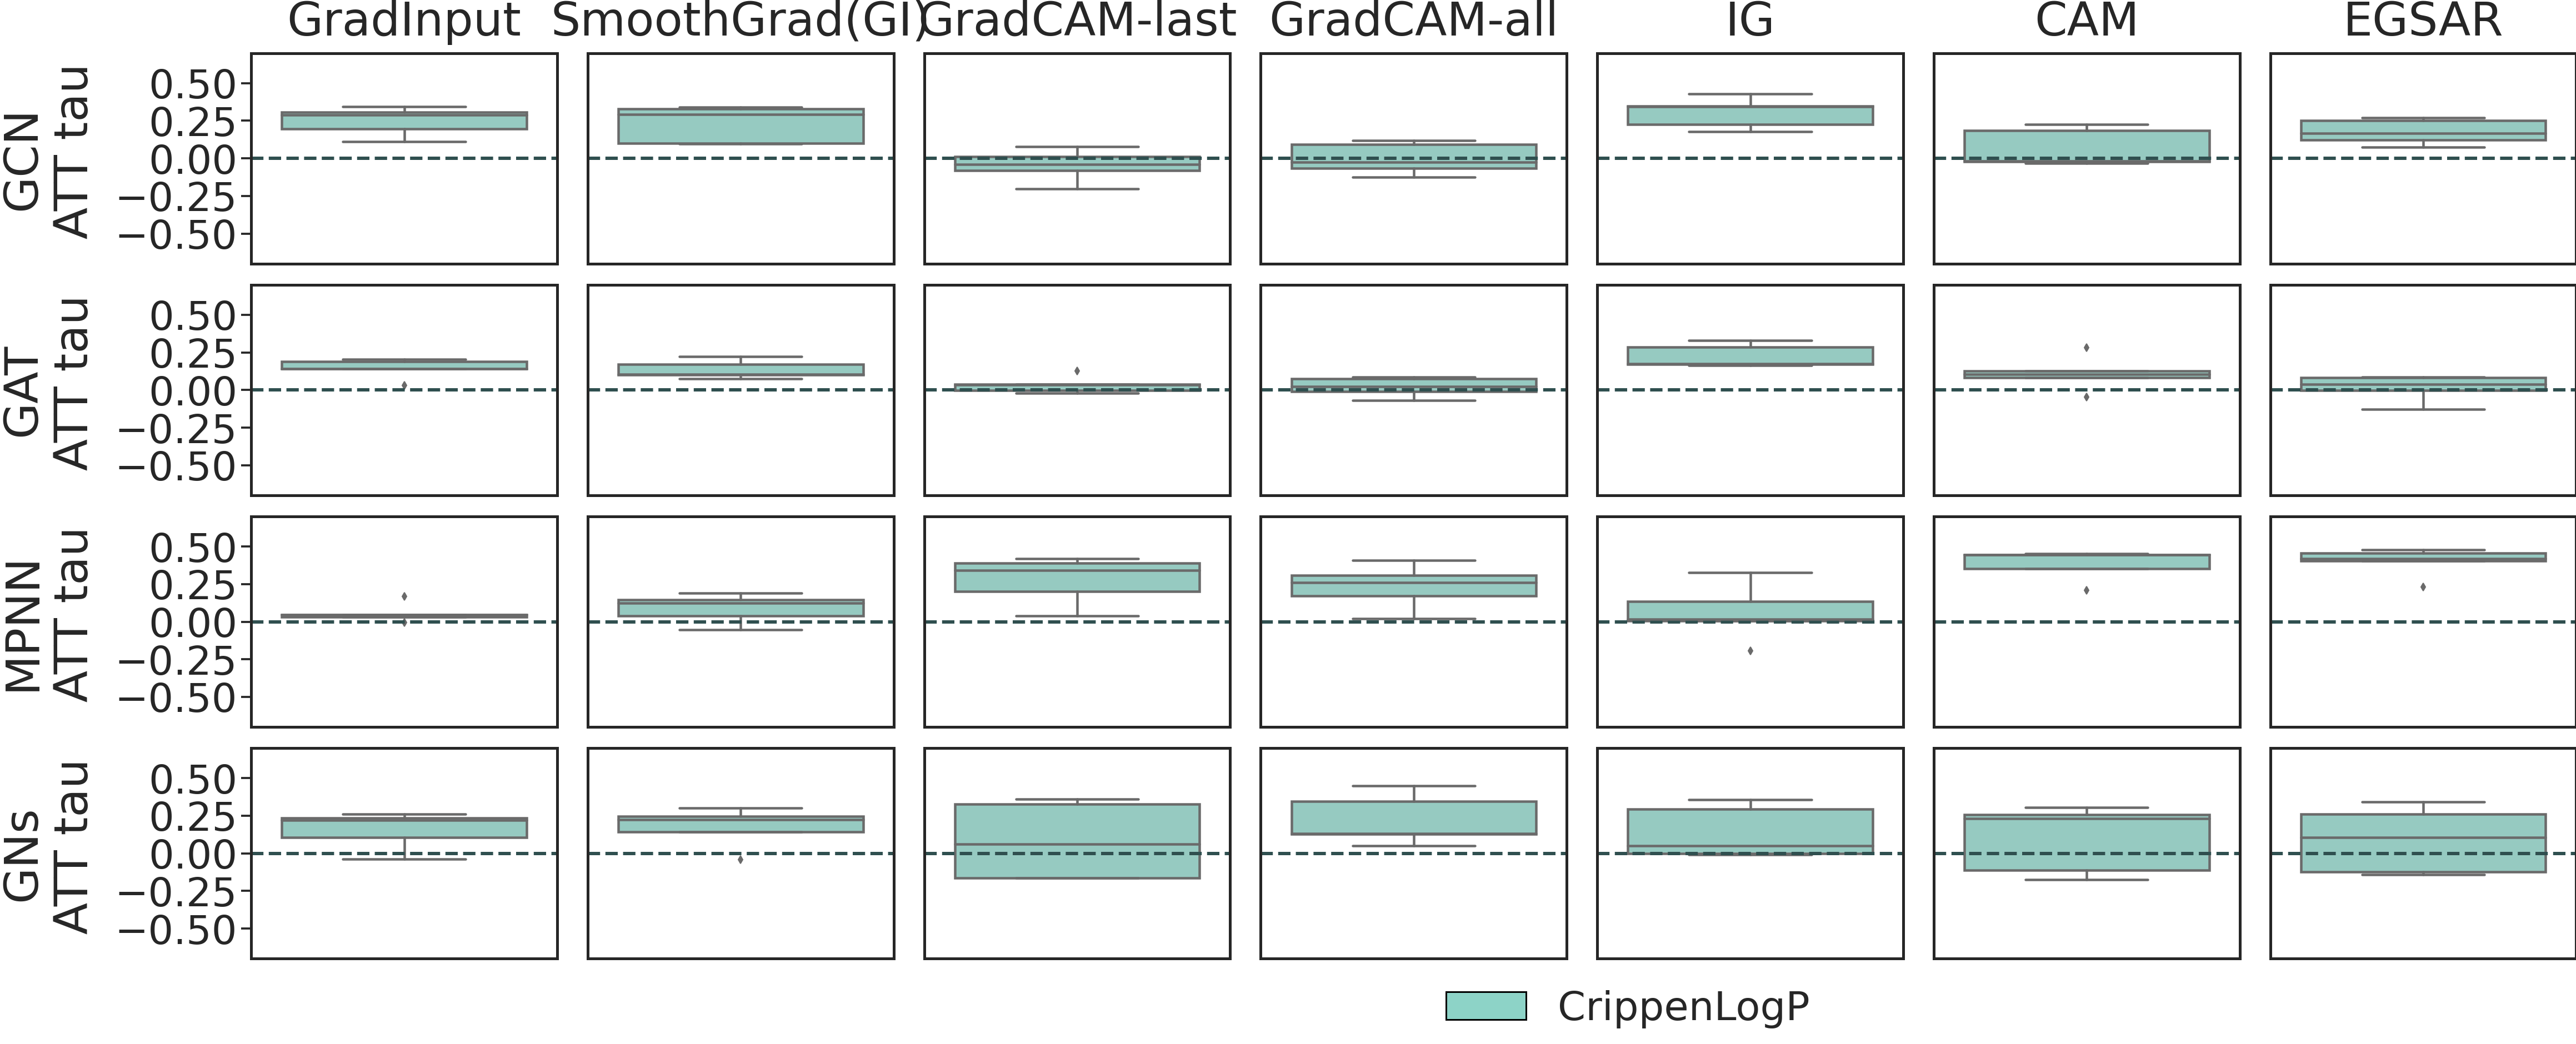

In [29]:
FIG_HEIGHT = 15
FIG_WIDTH_RATIO = 2.5
GRID_PADDING = 0.1
PALLETE = 'Set3'

fig_4_task_names = ['crippen']
fig_4_att_model_names = ['GradInput', 'SmoothGrad(GradInput)', 'GradCAM-last', 'GradCAM-all', 'IG', 'CAM', 'EGSAR']

fig, axes = plt.subplots(
    nrows=len(model_names),
    ncols=len(fig_4_att_model_names),
    figsize=(FIG_HEIGHT * FIG_WIDTH_RATIO, FIG_HEIGHT),
)
draw_legend_ax = None

for block_idx, block_name in enumerate(model_names):
    for tech_idx, technique_name in enumerate(fig_4_att_model_names):

        # get the dataframe
        tmp_df = df_exp_result_fig4_reg.query('Technique=="{}" and block_type=="{}"'.format(
            technique_name, block_name))

        # draw figures
        ax = plt.subplot(
            len(model_names), len(fig_4_att_model_names),
            1 + block_idx * len(fig_4_att_model_names) + tech_idx)
        sns.boxplot(
            x='task_type',
            y='ATT tau',
            data=tmp_df,
            palette=PALLETE,
            order=fig_4_task_names)
        plt.axhline(0, linestyle='--', color='darkslategray', linewidth=3)
        plt.ylabel('')
        plt.xlabel('')
        plt.xticks([], [])
        ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
        plt.ylim(-0.7, 0.7)

        # setup grid
        if block_idx == 0:
            plt.title(get_nicename(technique_name), pad=16, fontsize=42)
        if tech_idx == 0:
            ax.set_ylabel(
              '{}\n ATT tau'.format(get_nicename(block_name)),
              labelpad=16,
              fontsize=42)
        if tech_idx != 0:
            plt.yticks([], [])
        else:
            ax.tick_params(axis='y', labelsize=36)
        if tech_idx == 5 and block_idx == len(model_names) - 1:
            draw_legend_ax = ax

# update the subplot spacing
plt.subplots_adjust(hspace=GRID_PADDING, wspace=GRID_PADDING)
# draw the legend
legend_elements = [
    patches.Patch(facecolor=c, edgecolor='k', label=get_nicename(t))
    for t, c in zip(
        fig_4_task_names,
        matplotlib.cm.get_cmap(PALLETE).colors[:len(fig_4_task_names)])
]
draw_legend_ax.legend(
    handles=legend_elements,
    ncol=len(fig_4_task_names),
    loc=8,
    fontsize=36,
    bbox_to_anchor=(-1, -0.5),
    frameon=False)
plt.show()
fig.savefig('suppl_figure1_reg.png', format='png', dpi=500, bbox_inches='tight', pad_inches=0)